In [413]:
import pandas as pd
from scipy import stats
import numpy as np
from statsmodels.stats.proportion import proportion_confint
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [414]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [415]:
data.shape

(30000, 25)

In [416]:
data.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

# 1. Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы

In [417]:
limit_bal_def = data[data['default']== 1]['LIMIT_BAL']
limit_bal_not_def = data[data['default']== 0]['LIMIT_BAL']

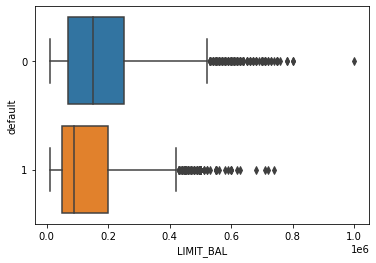

In [418]:
sns.boxplot(x='LIMIT_BAL', y='default', data=data, orient='h')

In [419]:
limit_bal_def.describe()

count      6636.000000
mean     130109.656420
std      115378.540571
min       10000.000000
25%       50000.000000
50%       90000.000000
75%      200000.000000
max      740000.000000
Name: LIMIT_BAL, dtype: float64

In [420]:
limit_bal_not_def.describe()

count      23364.000000
mean      178099.726074
std       131628.359660
min        10000.000000
25%        70000.000000
50%       150000.000000
75%       250000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

# a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

In [421]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [422]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [423]:
len(limit_bal_def.values)

6636

In [424]:
len(limit_bal_not_def.values)

23364

In [425]:
get_bootstrap_samples(limit_bal_def.values).shape

(1000, 6636)

In [426]:
limit_bal_def_med_score = list(map(np.median, get_bootstrap_samples(limit_bal_def.values)))

In [427]:
limit_bal_no_def_med_score = list(map(np.median, get_bootstrap_samples(limit_bal_not_def.values)))

In [428]:
print("95% confidence interval for the no default median score:",  stat_intervals(limit_bal_def_med_score, 0.05))
print("95% confidence interval for the default median score:",  stat_intervals(limit_bal_no_def_med_score, 0.05))

95% confidence interval for the no default median score: [80000. 90000.]
95% confidence interval for the default median score: [150000. 150000.]


In [429]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(limit_bal_def_med_score, limit_bal_no_def_med_score)))

In [430]:
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [60000. 70000.]


Проверяется гипотеза о равенстве медианных значений кредитного лимита в двух группах. Нулевая гипотеза - медианные значения равны против альтернативы - медианные значения не равны. Нулевая гипотеза отвергается на уровне значимости 0.05 с помощью интервальной оценки разности медиан, полученных из подвыборок по методу бутстрепа.

#  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних


In [431]:
stats.mannwhitneyu(limit_bal_def,limit_bal_not_def )

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Проверяется гипотеза о равенстве медианных значений кредитного лимита в двух группах. Нулевая гипотеза - медианные значения равны против альтернативы - медианные значения не равны. Нулевая гипотеза о равенстве распределений  в двух группах отвергается с помощью непараметрического критерия Манна-Уитни на уровне значимости 0.05 с достигаемым уровнем значимости  6.127742909111652e-190. Критерий Манна-Уитни применим для независимых выборок в задачах оценки равенства распределений их генеральных совокупностей. Условия применимости критерия выполняются. 

Результат имеет практическую значимость, так как подтверждает, что заемщикам, не вернувшим кредит, юыло установлено медианное значения кредитного лимита, отличающееся от значения для группы, вернувшей кредит. Это подтверждает правильность политики банка по установлению кредитного лимита.

# 2.Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается

In [432]:
sex_default = data[data['default'] == 1].SEX - 1

In [433]:
sex_not_default = data[data['default'] == 0].SEX - 1

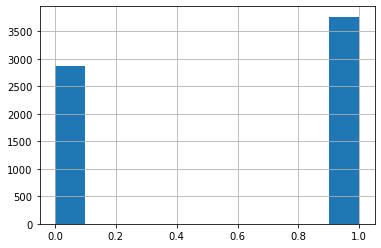

In [434]:
sex_default.hist()

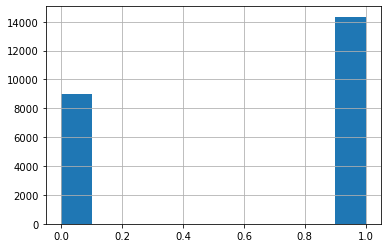

In [435]:
sex_not_default.hist()

In [436]:
sex_default.value_counts()

1    3763
0    2873
Name: SEX, dtype: int64

In [437]:
sex_not_default.value_counts()

1    14349
0     9015
Name: SEX, dtype: int64

In [438]:
sex_not_default.value_counts()

1    14349
0     9015
Name: SEX, dtype: int64

In [439]:
sex_default.value_counts()

1    3763
0    2873
Name: SEX, dtype: int64

# Решение с помощью доверительного интервала

In [440]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [441]:
proportions_diff_confint_ind(sex_not_default, sex_default)

(0.03363493274962867, 0.060548077974896725)

In [442]:
conf_interval_default = proportion_confint(sum(sex_default), 
                                            sex_default.shape[0],
                                            method = 'wilson')
conf_interval_not_default = proportion_confint(sum(sex_not_default), 
                                            sex_not_default.shape[0],
                                            method = 'wilson')

In [443]:
conf_interval_default, conf_interval_not_default

((0.5551017630282817, 0.578937581965066),
 (0.607889734030124, 0.6203726841910749))

95% доверительный интервал для разности долей мужчин и женщин в выборках вернувших и не вернувших кредит не включает ноль. Доверительные интервалы Уилсона для двух выборок не пересекаются. Таким образом, подтверждается гипотеза о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Доверительный интервал Уилсона для доли применим в случае биномиального распределения выборки.

# Точечная оценка с помощью Z-критерия для доли в двух независимых выборках

In [444]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [445]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [446]:
proportions_diff_z_stat_ind(sex_not_default, sex_default)

6.921375088562897

In [447]:
p_value = 2* (1- stats.norm.cdf(proportions_diff_z_stat_ind(sex_not_default, sex_default)))
p_value

4.472866521609831e-12

In [448]:
proportions_diff_z_test(proportions_diff_z_stat_ind(sex_not_default, sex_default))

4.472866521609831e-12

Проверяется гипотеза о различии гендерного состава группы людей вернувших и не вернувших кредит. Нулевая гипотеза - гендерный состав в группах не отличается, проверяется против альтернативной - гендерный состав в группах отличается.
Нулевая гипотеза отвергается на уровне значимости 0.01, полученный с помошью Z-статистики достигаемый ровень значимости  4.472866521609831e-12. Таким образом гипотеза о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается может быть принята на уровне знаимости 0.01 (с вероятностью 99%). 
Z-критерий для доли для двух независимых выборок применим, так как выборки являются независимыми (различные люди, вернувшие либо не вернувшие кредит), а распределение полов описывается биномиальным распределением, т.е. можно вычислить долю мужчин и женщин.

# Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.

In [537]:
education_default = data[data['default'] == 1]['EDUCATION']
education_not_default = data[data['default'] == 0]['EDUCATION']

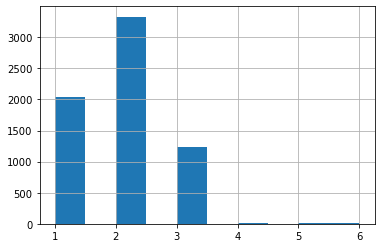

In [538]:
education_default.hist()

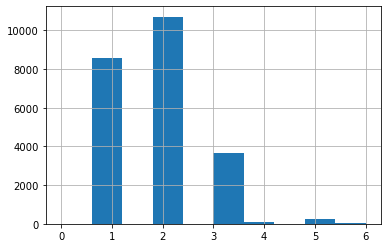

In [539]:
education_not_default.hist()

In [540]:
edu_not_default = pd.DataFrame(education_not_default.value_counts()).transpose()
edu_not_default.rename(index={'EDUCATION': 'NOT DEFAULT'}, inplace=True)
edu_not_default

,2,1,3,5,4,6,0
NOT DEFAULT,10700,8549,3680,262,116,43,14


In [541]:
edu_default = pd.DataFrame(education_default.value_counts()).transpose()
edu_default.rename(index={'EDUCATION': 'DEFAULT'}, inplace=True)
edu_default

,2,1,3,5,6,4
DEFAULT,3330,2036,1237,18,8,7


In [542]:
edu_confusion_matrix = pd.concat([edu_not_default, edu_default])
edu_confusion_matrix

,0,1,2,3,4,5,6
NOT DEFAULT,14.0,8549,10700,3680,116,262,43
DEFAULT,NaN,2036,3330,1237,7,18,8


In [543]:
edu_confusion_matrix.fillna(0, inplace=True)
edu_confusion_matrix

,0,1,2,3,4,5,6
NOT DEFAULT,14.0,8549,10700,3680,116,262,43
DEFAULT,0.0,2036,3330,1237,7,18,8


In [570]:
expected_matrix = pd.DataFrame(stats.chi2_contingency(edu_confusion_matrix)[3])
expected_matrix.rename(index={0: 'NOT DEFAULT', 1: 'DEFAULT'}, inplace=True)
expected_matrix

,0,1,2,3,4,5,6
NOT DEFAULT,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188
DEFAULT,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812


In [569]:
chi2 = stats.chi2_contingency(edu_confusion_matrix)
chi2 

(163.21655786997073,
 1.2332626245415605e-32,
 6,
 array([[1.0903200e+01, 8.2435980e+03, 1.0926564e+04, 3.8293596e+03,
         9.5792400e+01, 2.1806400e+02, 3.9718800e+01],
        [3.0968000e+00, 2.3414020e+03, 3.1034360e+03, 1.0876404e+03,
         2.7207600e+01, 6.1936000e+01, 1.1281200e+01]]))

Проверяется гипотеза о связи между образованием и погашением долга. Нулевая гипотеза, что связи нет проверяется против альтернативной, что связь есть. 
Значение статистики Хи-квадрат 163 при достигаемом уровне значимости 1.2332626245415605e-32 позволяет на уровне значимости 0.01 отвергнуть нулевую гипотезу и принять альтернативную, о том, что образование влияет на то, вернет ли человек долг. 

В качестве способа наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг составим таблицу сопряженности "образование" на "возврат долга", где значением ячейки будет разность между наблюдаемым и ожидаемым количеством человек. 

Таблица сопряженности "образование" на "возврат долга", где значением ячейки будет разность между наблюдаемым и ожидаемым количеством человек, выглядит так:

In [550]:
edu_confusion_matrix_diff = edu_confusion_matrix - expected_matrix
edu_confusion_matrix_diff

,0,1,2,3,4,5,6
NOT DEFAULT,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
DEFAULT,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


Для модификации таблицы так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости, нормируем их. Для этого вычтем из каждого значения минимальное по каждой строке и разделим на разность максимального и минимального значений по строке

In [551]:
not_default_max = edu_confusion_matrix_diff.loc['NOT DEFAULT',:].max()
not_default_min = edu_confusion_matrix_diff.loc['NOT DEFAULT',:].min()

In [552]:
default_max = edu_confusion_matrix_diff.loc['DEFAULT',:].max()
default_min = edu_confusion_matrix_diff.loc['DEFAULT',:].min()

In [553]:
edu_confusion_matrix_modified.loc['NOT DEFAULT',:] = (edu_confusion_matrix_diff.loc['NOT DEFAULT',:] - not_default_min)/(not_default_max - not_default_min)

In [554]:
edu_confusion_matrix_modified.loc['DEFAULT',:] = (edu_confusion_matrix_diff.loc['DEFAULT',:] - default_min)/(default_max - default_min)

Модифицированная таблица, со значениями ячеек, приведенными к одному масштабу без потери в интерпретируемости

In [555]:
edu_confusion_matrix_modified

,0,1,2,3,4,5,6
NOT DEFAULT,0.431721,1.0,0.0,0.14513,0.463886,0.508491,0.432067
DEFAULT,0.568279,0.0,1.0,0.85487,0.536114,0.491509,0.567933


Наличие образования с индексом 1 (магистр) является наилучшим индикатором того, что человек отдаст долг. Наличие образования с индексом 2 (бакалавр) является наилучшим индикатором того, что человек не отдаст долг.

# Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [469]:
marriage_default = data[data['default'] == 1]['MARRIAGE']
marriage_not_default = data[data['default'] == 0]['MARRIAGE']

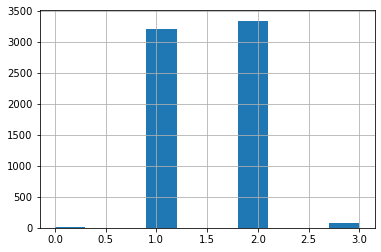

In [470]:
marriage_default.hist()

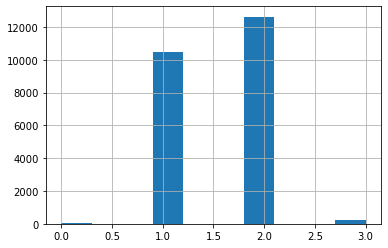

In [471]:
marriage_not_default.hist()

In [472]:
marr_not_default = pd.DataFrame(marriage_not_default.value_counts()).transpose()
marr_not_default.rename(index={'MARRIAGE': 'NOT DEFAULT'}, inplace=True)
marr_not_default

,2,1,3,0
NOT DEFAULT,12623,10453,239,49


In [473]:
marr_default = pd.DataFrame(marriage_default.value_counts()).transpose()
marr_default.rename(index={'MARRIAGE': 'DEFAULT'}, inplace=True)
marr_default

,2,1,3,0
DEFAULT,3341,3206,84,5


In [474]:
marr_confusion_matrix = pd.concat([marr_not_default, marr_default])
marr_confusion_matrix

,2,1,3,0
NOT DEFAULT,12623,10453,239,49
DEFAULT,3341,3206,84,5


Критерий хи-квадрат для таблиц сопряженности может применяться при выполнении следующих условий.
Нужно, чтобы выборки были достаточно большими: n ≥ 40. Кроме того, необходимо, чтобы ожидаемое
количество элементов в каждой ячейке таблицы было меньше 5, не более, чем в 20% ячеек. В нашем случае условия примениости выполняются.

In [572]:
marr_chi2 = stats.chi2_contingency(marr_confusion_matrix)[0]
marr_chi2 

35.66239583433609

In [573]:
n = marr_confusion_matrix.sum().sum()
n

30000

In [574]:
V = np.sqrt(marr_chi2/(n*min(confusion_matrix.shape[0], confusion_matrix.shape[1]) - 1))
V

0.024379974780376065

В качестве меры, по которой можно измерить возможную связь семейного статуса с индикатором дефолта предложен коэффицент Крамера. Величина коэффициента 0.024379974780376065 говорит о слабой зависимости. Использование коэффициента Крамера применимо в задачах поиска связи между категориальными признаками (в нашем случае семейный статус и погашение долга).

# Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: 

# a) о равенстве медианных значений возрастов людей 

In [478]:
age_default = data[data['default'] == 1]['AGE']
age_not_default = data[data['default'] == 0]['AGE']

In [479]:
age_default.describe()

count    6636.000000
mean       35.725738
std         9.693438
min        21.000000
25%        28.000000
50%        34.000000
75%        42.000000
max        75.000000
Name: AGE, dtype: float64

In [480]:
age_not_default.describe()

count    23364.000000
mean        35.417266
std          9.077355
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

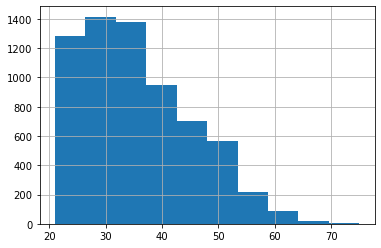

In [481]:
age_default.hist()

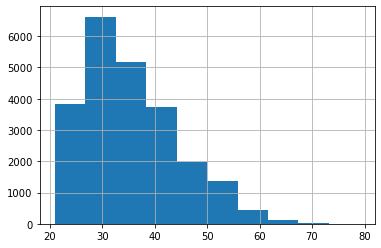

In [482]:
age_not_default.hist()

In [483]:
age_def_med_score = list(map(np.median, get_bootstrap_samples(age_default.values)))

In [484]:
age_not_def_med_score = list(map(np.median, get_bootstrap_samples(age_not_default.values)))

In [485]:
print("95% confidence interval for the age no default median score:",  stat_intervals(age_not_def_med_score, 0.05))
print("95% confidence interval for the age default median score:",  stat_intervals(age_def_med_score, 0.05))

95% confidence interval for the age no default median score: [34. 34.]
95% confidence interval for the age default median score: [34. 35.]


In [486]:
age_delta_median_scores = list(map(lambda x: x[1] - x[0], zip(age_not_def_med_score, age_def_med_score)))

In [487]:
print("95% confidence interval for the difference between age medians",  stat_intervals(age_delta_median_scores, 0.05))

95% confidence interval for the difference between age medians [0. 1.]


Проверяется гипотеза о равенстве медиан возрастов в группах вернувших и не вернувших кредит. Нулевая гипотеза, что медианы возрастов равны, проверяется против альтернативной, что медианы возрастов не равны. 
Доверительный интервал для разности медиан возрастов в группах вернувших и не вернувщих кредит с 95% вероятностью включает ноль. Таким образом, гипотеза о равенстве медиан возрастов не отвергается. 

# b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [488]:
stats.mannwhitneyu(age_not_default,age_default)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Проверяется гипотеза о равенстве распределений возрастов в группах вернувших и не вернувших кредит. Нулевая гипотеза, что распределения возрастов равны проверяется против альтернативной, что распределения не равны.
Достигаемый кровень значимости непараметрического критерия Манна-Уитни 0.1862517717449308 не позволяет отвергнуть гипотезу о равенстве распределений на уровне значимости 0.05. Критерий применим для независимых выборок в задачах оценки равенства распределений их генеральных совокупностей. Условия применимости критерия выполняются. 
С практической точки зрения этот результат значим, так как позволяет исключить признак возраст из рассмотрения при расчете кредитного скоринга.